In [1]:
%matplotlib inline
%config InlineBackend.figure_format = 'svg'

import GPy
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import climin
from scipy.optimize import fmin_l_bfgs_b
%matplotlib inline
%config InlineBackend.figure_format = 'svg'
plt.rcParams['figure.figsize'] = 8,8
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

In [2]:
# use the protein dataset
data = pd.read_csv('protein.csv', header=None)
data.head()

,0,1,2,3,4,5,6,7,8,9
0,13558.30,4305.35,0.31754,162.1730,1.872791e+06,215.3590,4287.87,102.0,27.0302,17.284
1,6191.96,1623.16,0.26213,53.3894,8.034467e+05,87.2024,3328.91,39.0,38.5468,6.021
2,7725.98,1726.28,0.22343,67.2887,1.075648e+06,81.7913,2981.04,29.0,38.8119,9.275
3,8424.58,2368.25,0.28111,67.8325,1.210472e+06,109.4390,3248.22,70.0,39.0651,15.851
4,7460.84,1736.94,0.23280,52.4123,1.021020e+06,94.5234,2814.42,41.0,39.9147,7.962


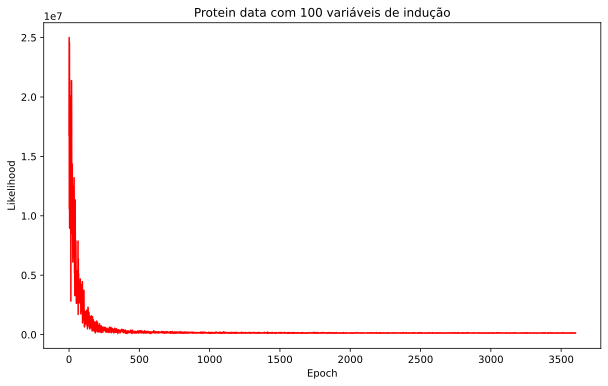

In [84]:
import pandas as pd
treino_data = pd.read_csv('100_indu.csv')
# treino = itereation,likelihood,RMSE,noise_variance,rbf_lengthscale,rbf_variance



#plot the data
plt.figure(figsize=(10,6))
plt.plot(treino_data['epochs'], treino_data['batch_likelihood'], 'r')
plt.xlabel('Epoch')
plt.ylabel('Likelihood')
plt.title('Protein data com 100 variáveis de indução')
plt.show()


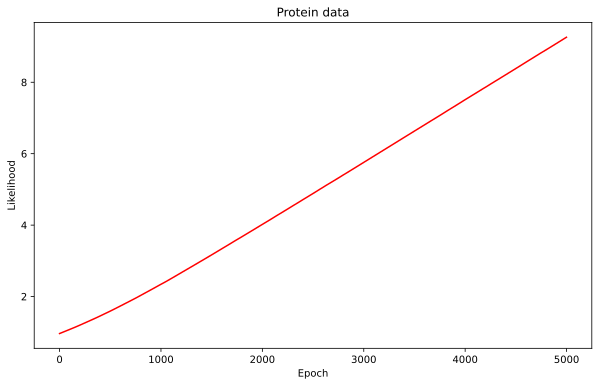

In [74]:
plt.figure(figsize=(10,6))
plt.plot(treino_data['epochs'], treino_data['Noise Variance'], 'r')
plt.xlabel('Epoch')
plt.ylabel('Likelihood')
plt.title('Protein data')
plt.show()

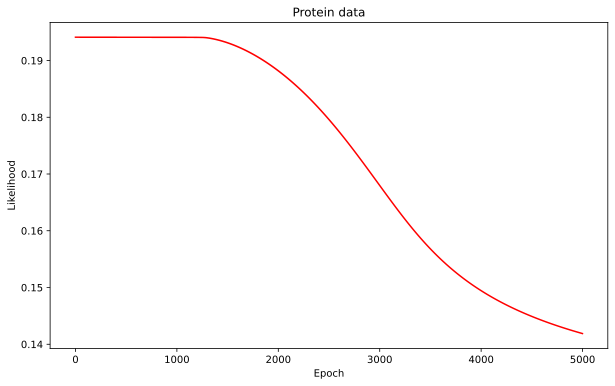

In [75]:

plt.figure(figsize=(10,6))
plt.plot(treino_data['epochs'], treino_data['RBF Lengthscale'], 'r')
plt.xlabel('Epoch')
plt.ylabel('Likelihood')
plt.title('Protein data')
plt.show()

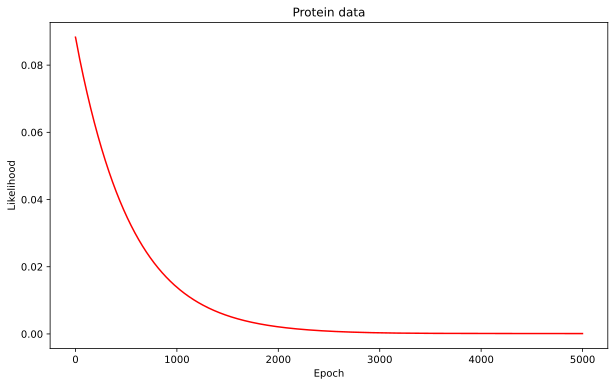

In [76]:
plt.figure(figsize=(10,6))
plt.plot(treino_data['epochs'], treino_data['RBF Variance'], 'r')
plt.xlabel('Epoch')
plt.ylabel('Likelihood')
plt.title('Protein data')
plt.show()

Text(0.5, 1.0, 'Protein data')

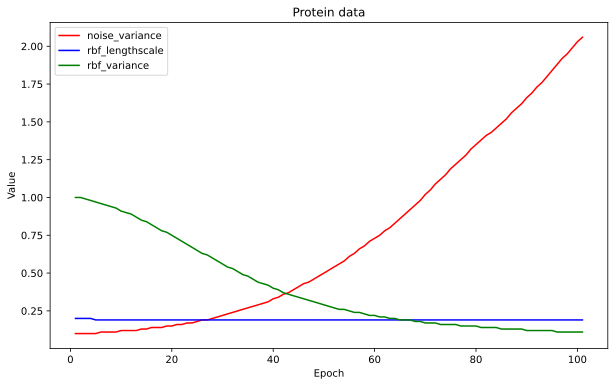

In [32]:
# plot the noise_variance,rbf_lengthscale,rbf_variance
plt.figure(figsize=(10, 6))
plt.plot(treino_data['iteration'], treino_data['noise_variance'], 'r')
plt.plot(treino_data['iteration'], treino_data['rbf_lengthscale'], 'b')
plt.plot(treino_data['iteration'], treino_data['rbf_variance'], 'g')
plt.xlabel('Epoch')
plt.ylabel('Value')
plt.legend(['noise_variance', 'rbf_lengthscale', 'rbf_variance'])
plt.title('Protein data')

In [48]:
X =  data.iloc[:, :-1].values
y =  data.iloc[:, -1].values
y.shape = (len(y), 1)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [85]:
N_inducing=200
batchsize = 10
step_rate = 0.1
momentum = 0.9
iterations = 1000

Z_x = np.random.rand(N_inducing, X_train.shape[1])
m = GPy.core.SVGP(X_train, y_train, Z_x, GPy.kern.RBF(9), GPy.likelihoods.Gaussian(), batchsize=batchsize)

m.kern.lengthscale = 0.2
m.kern.variance = 1.0
m.likelihood.variance = 0.1

print(m)


Name : SVGP
Objective : 14954200.097237956
Number of Parameters : 22103
Number of Optimization Parameters : 22103
Updates : True
Parameters:
  SVGP.                    |       value  |  constraints  |  priors
  inducing_inputs          |    (200, 9)  |               |        
  rbf.variance             |         1.0  |      +ve      |        
  rbf.lengthscale          |         0.2  |      +ve      |        
  Gaussian_noise.variance  |         0.1  |      +ve      |        
  q_u_chol                 |  (20100, 1)  |               |        
  q_u_mean                 |    (200, 1)  |               |        


In [86]:
opt = climin.Adadelta(m.optimizer_array, m.stochastic_grad, step_rate=step_rate, momentum=momentum)

# save the initial loss, batch likelikelihood, rmse, salve all gp parameters 
batch_likelihood_list = []
rmse_list = []
noise_variance_list = []
rbf_lengthscale_list = []
rbf_variance_list = []

def callback(i):
    if i['n_iter'] % 2 == 0:
        return True
    return False

def optmize():
    for i in range(iterations*10+1):
        info = opt.minimize_until(callback)
        m._trigger_params_changed()
        batch_likelihood = m._objective(m.optimizer_array)
        MNLL = np.mean(-m.log_predictive_density(X_test, y_test))
        noise_variance = m.likelihood.variance.values
        rbf_lengthscale = m.kern.lengthscale.values
        rbf_variance = m.kern.variance.values
        print('Epoch: ', i, 'Batch Likelihood: ', batch_likelihood, 'MNLL: ', MNLL, 
              'Noise Variance: ', noise_variance, 'RBF Lengthscale: ', rbf_lengthscale, 
              'RBF Variance: ', rbf_variance)
        
optmize()


Epoch:  0 Batch Likelihood:  17199721.752911314 MNLL:  45.38767782529232 Noise Variance:  [0.10057332] RBF Lengthscale:  [0.19891367] RBF Variance:  [0.99620621]
Epoch:  1 Batch Likelihood:  25177219.575950984 MNLL:  45.66059922253263 Noise Variance:  [0.1016577] RBF Lengthscale:  [0.19706536] RBF Variance:  [0.98834911]
Epoch:  2 Batch Likelihood:  19603240.570607666 MNLL:  46.01222139738869 Noise Variance:  [0.10319923] RBF Lengthscale:  [0.19525829] RBF Variance:  [0.97820484]
Epoch:  3 Batch Likelihood:  23923088.502237726 MNLL:  46.422861658186406 Noise Variance:  [0.10492594] RBF Lengthscale:  [0.19384911] RBF Variance:  [0.96660273]
Epoch:  4 Batch Likelihood:  27734470.82865115 MNLL:  46.86804206786283 Noise Variance:  [0.10701482] RBF Lengthscale:  [0.1929334] RBF Variance:  [0.95401066]
Epoch:  5 Batch Likelihood:  12478739.090486847 MNLL:  47.34415035590001 Noise Variance:  [0.10929214] RBF Lengthscale:  [0.19246216] RBF Variance:  [0.94072718]
Epoch:  6 Batch Likelihood:  1

In [65]:
# SAVE batch_likelihood_list
batch_likelihood_list = pd.DataFrame(batch_likelihood_list)
batch_likelihood_list.to_csv('batch_likelihood_list.csv', index=False) 
rmse_list = pd.DataFrame(rmse_list)
rmse_list.to_csv('rmse_list.csv', index=False)
noise_variance_list = pd.DataFrame(noise_variance_list)
noise_variance_list.to_csv('noise_variance_list.csv', index=False)
rbf_lengthscale_list = pd.DataFrame(rbf_lengthscale_list)
rbf_lengthscale_list.to_csv('rbf_lengthscale_list.csv', index=False)
rbf_variance_list = pd.DataFrame(rbf_variance_list)
rbf_variance_list.to_csv('rbf_variance_list.csv', index=False)

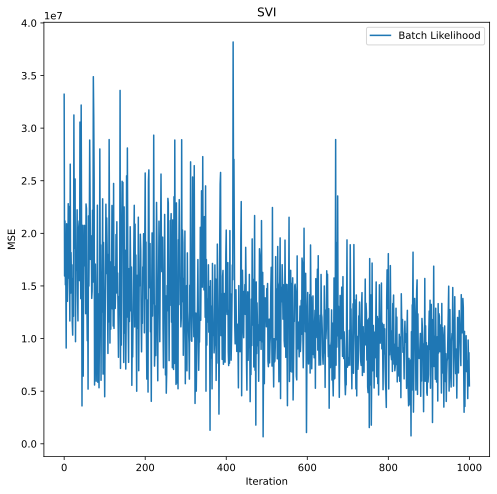

In [46]:
#plot errors
# plt.plot(rmse_list, label='RMSE')
plt.plot(batch_likelihood_list, label='Batch Likelihood')
# plt.plot(noise_variance_list, label='Noise Variance')
# plt.plot(rbf_lengthscale_list, label='RBF Lengthscale')
# plt.plot(rbf_variance_list, label='RBF Variance')
plt.title('SVI')
plt.legend()
plt.xlabel('Iteration')
plt.ylabel('MSE')
plt.show()


In [87]:
# j = GPy.core.SparseGP(X_train, y_train, Z_x, GPy.kern.RBF(9), GPy.likelihoods.Gaussian(), batchsize=batchsize)
# j.optimize('bfgs')
# plot the data


('defaulting to ', <GPy.inference.latent_function_inference.var_dtc.VarDTC object at 0x0000026E8C682B70>, 'for latent function inference')


AttributeError: 'SparseGP' object has no attribute 'log_likelihoods'

<Figure size 720x432 with 0 Axes>

In [94]:
l = GPy.core.SparseGP(X_train, y_train, Z_x, GPy.kern.RBF(9), GPy.likelihoods.Gaussian())

print(l)

TypeError: __init__() got an unexpected keyword argument 'batchsize'

In [97]:
print(j)

# predict the test data
y_pred, _ = m.predict(X_test)
y_pred = np.array(y_pred)
y_pred.shape = (len(y_pred), 1)

#mnll
mnll = np.mean(-m.log_predictive_density(X_test, y_test))
print('MNLL: ', mnll)




Name : sparse gp
Objective : 135681.33456504557
Number of Parameters : 1803
Number of Optimization Parameters : 1803
Updates : True
Parameters:
  sparse_gp.               |                  value  |  constraints  |  priors
  inducing_inputs          |               (200, 9)  |               |        
  rbf.variance             |  1.310200151927246e-06  |      +ve      |        
  rbf.lengthscale          |                    1.0  |      +ve      |        
  Gaussian_noise.variance  |      97.48060819125571  |      +ve      |        
MNLL:  3.708662246314788
